In [2]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from time import perf_counter 
import os
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from tensorflow.keras.utils import plot_model
from keras.models import model_from_json
import cv2
import imageio
import platform
from tqdm import tqdm
from googleplaces import GooglePlaces, types

In [3]:
## Defining batch specfications
batch_size = 100
img_height = 250
img_width = 250

In [4]:
training_data = tf.keras.preprocessing.image_dataset_from_directory(
    'data/train',
    seed=42,
    image_size= (img_height, img_width),
    batch_size=batch_size,
    color_mode='rgb'
)

Found 791 files belonging to 2 classes.


In [5]:
## loading validation dataset
validation_data =  tf.keras.preprocessing.image_dataset_from_directory(
    'data/val',
    seed=42,
    image_size= (img_height, img_width),
    batch_size=batch_size,
    color_mode='rgb'
)

Found 98 files belonging to 2 classes.


In [6]:
## loading testing dataset
testing_data = tf.keras.preprocessing.image_dataset_from_directory(
    'data/test',
    seed=42,
    image_size= (img_height, img_width),
    batch_size=batch_size,
    color_mode='rgb'
)

Found 100 files belonging to 2 classes.


In [7]:
class_names = training_data.class_names
class_names

['Accident', 'Non Accident']

In [8]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
training_data = training_data.cache().prefetch(buffer_size=AUTOTUNE)
testing_data = testing_data.cache().prefetch(buffer_size=AUTOTUNE)
validation_data=validation_data.cache().prefetch(buffer_size=AUTOTUNE)

In [9]:
## Defining Cnn
model = tf.keras.models.Sequential([
  layers.BatchNormalization(),
  layers.Conv2D(32, 3, activation='relu'), # Conv2D(f_size, filter_size, activation) # relu, sigmoid, softmax
  layers.MaxPooling2D(), # MaxPooling
  layers.Conv2D(64, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(256, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(512, activation='relu'),
  layers.Dense(len(class_names), activation= 'softmax')
])

model.compile(optimizer='adam',loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [10]:
model.build((None, 250, 250, 3))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (Batch  (None, 250, 250, 3)       12        
 Normalization)                                                  
                                                                 
 conv2d (Conv2D)             (None, 248, 248, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 124, 124, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 122, 122, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 61, 61, 64)        0         
 g2D)                                                            
                                                        

In [11]:
## lets train our CNN
checkpoint = ModelCheckpoint("model_weights.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]
history = model.fit(training_data, validation_data=validation_data, epochs = 20, callbacks=callbacks_list)

Epoch 1/20
8/8 [==============================] - ETA: 0s - loss: 2.9478 - accuracy: 0.5019 
Epoch 1: val_accuracy improved from -inf to 0.46939, saving model to model_weights.h5


C:\Users\Mohammed Roshan\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


8/8 [==============================] - 95s 11s/step - loss: 2.9478 - accuracy: 0.5019 - val_loss: 0.7621 - val_accuracy: 0.4694
Epoch 2/20
8/8 [==============================] - ETA: 0s - loss: 0.6791 - accuracy: 0.5474 
Epoch 2: val_accuracy did not improve from 0.46939
8/8 [==============================] - 88s 11s/step - loss: 0.6791 - accuracy: 0.5474 - val_loss: 0.6916 - val_accuracy: 0.4694
Epoch 3/20
8/8 [==============================] - ETA: 0s - loss: 0.6290 - accuracy: 0.6448 
Epoch 3: val_accuracy did not improve from 0.46939
8/8 [==============================] - 84s 11s/step - loss: 0.6290 - accuracy: 0.6448 - val_loss: 1.0510 - val_accuracy: 0.4694
Epoch 4/20
8/8 [==============================] - ETA: 0s - loss: 0.5760 - accuracy: 0.7143 
Epoch 4: val_accuracy did not improve from 0.46939
8/8 [==============================] - 89s 11s/step - loss: 0.5760 - accuracy: 0.7143 - val_loss: 1.3909 - val_accuracy: 0.4694
Epoch 5/20
8/8 [==============================] - ETA: 0

We got a 90% accuracy

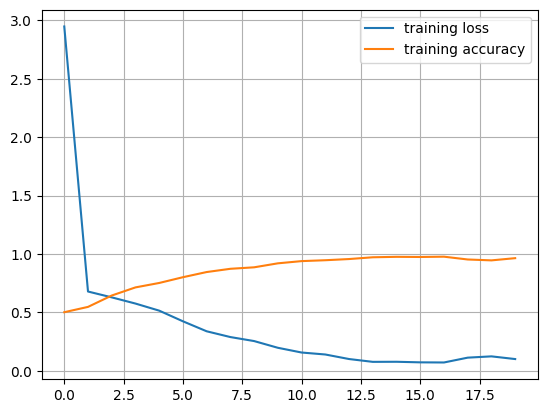

In [12]:
## stats on training data
plt.plot(history.history['loss'], label = 'training loss')
plt.plot(history.history['accuracy'], label = 'training accuracy')
plt.grid(True)
plt.legend()

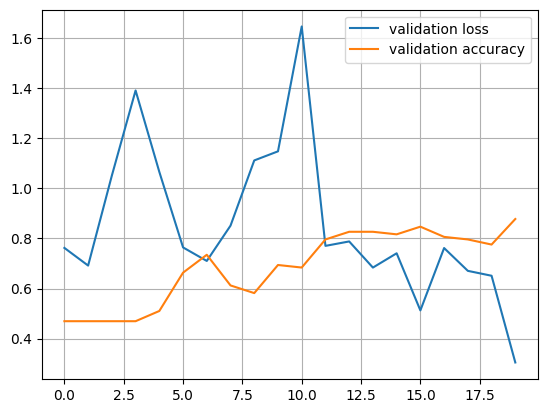

In [13]:
## stats on training data
plt.plot(history.history['val_loss'], label = 'validation loss')
plt.plot(history.history['val_accuracy'], label = 'validation accuracy')
plt.grid(True)
plt.legend()

4/4 [==============================] - 2s 507ms/step


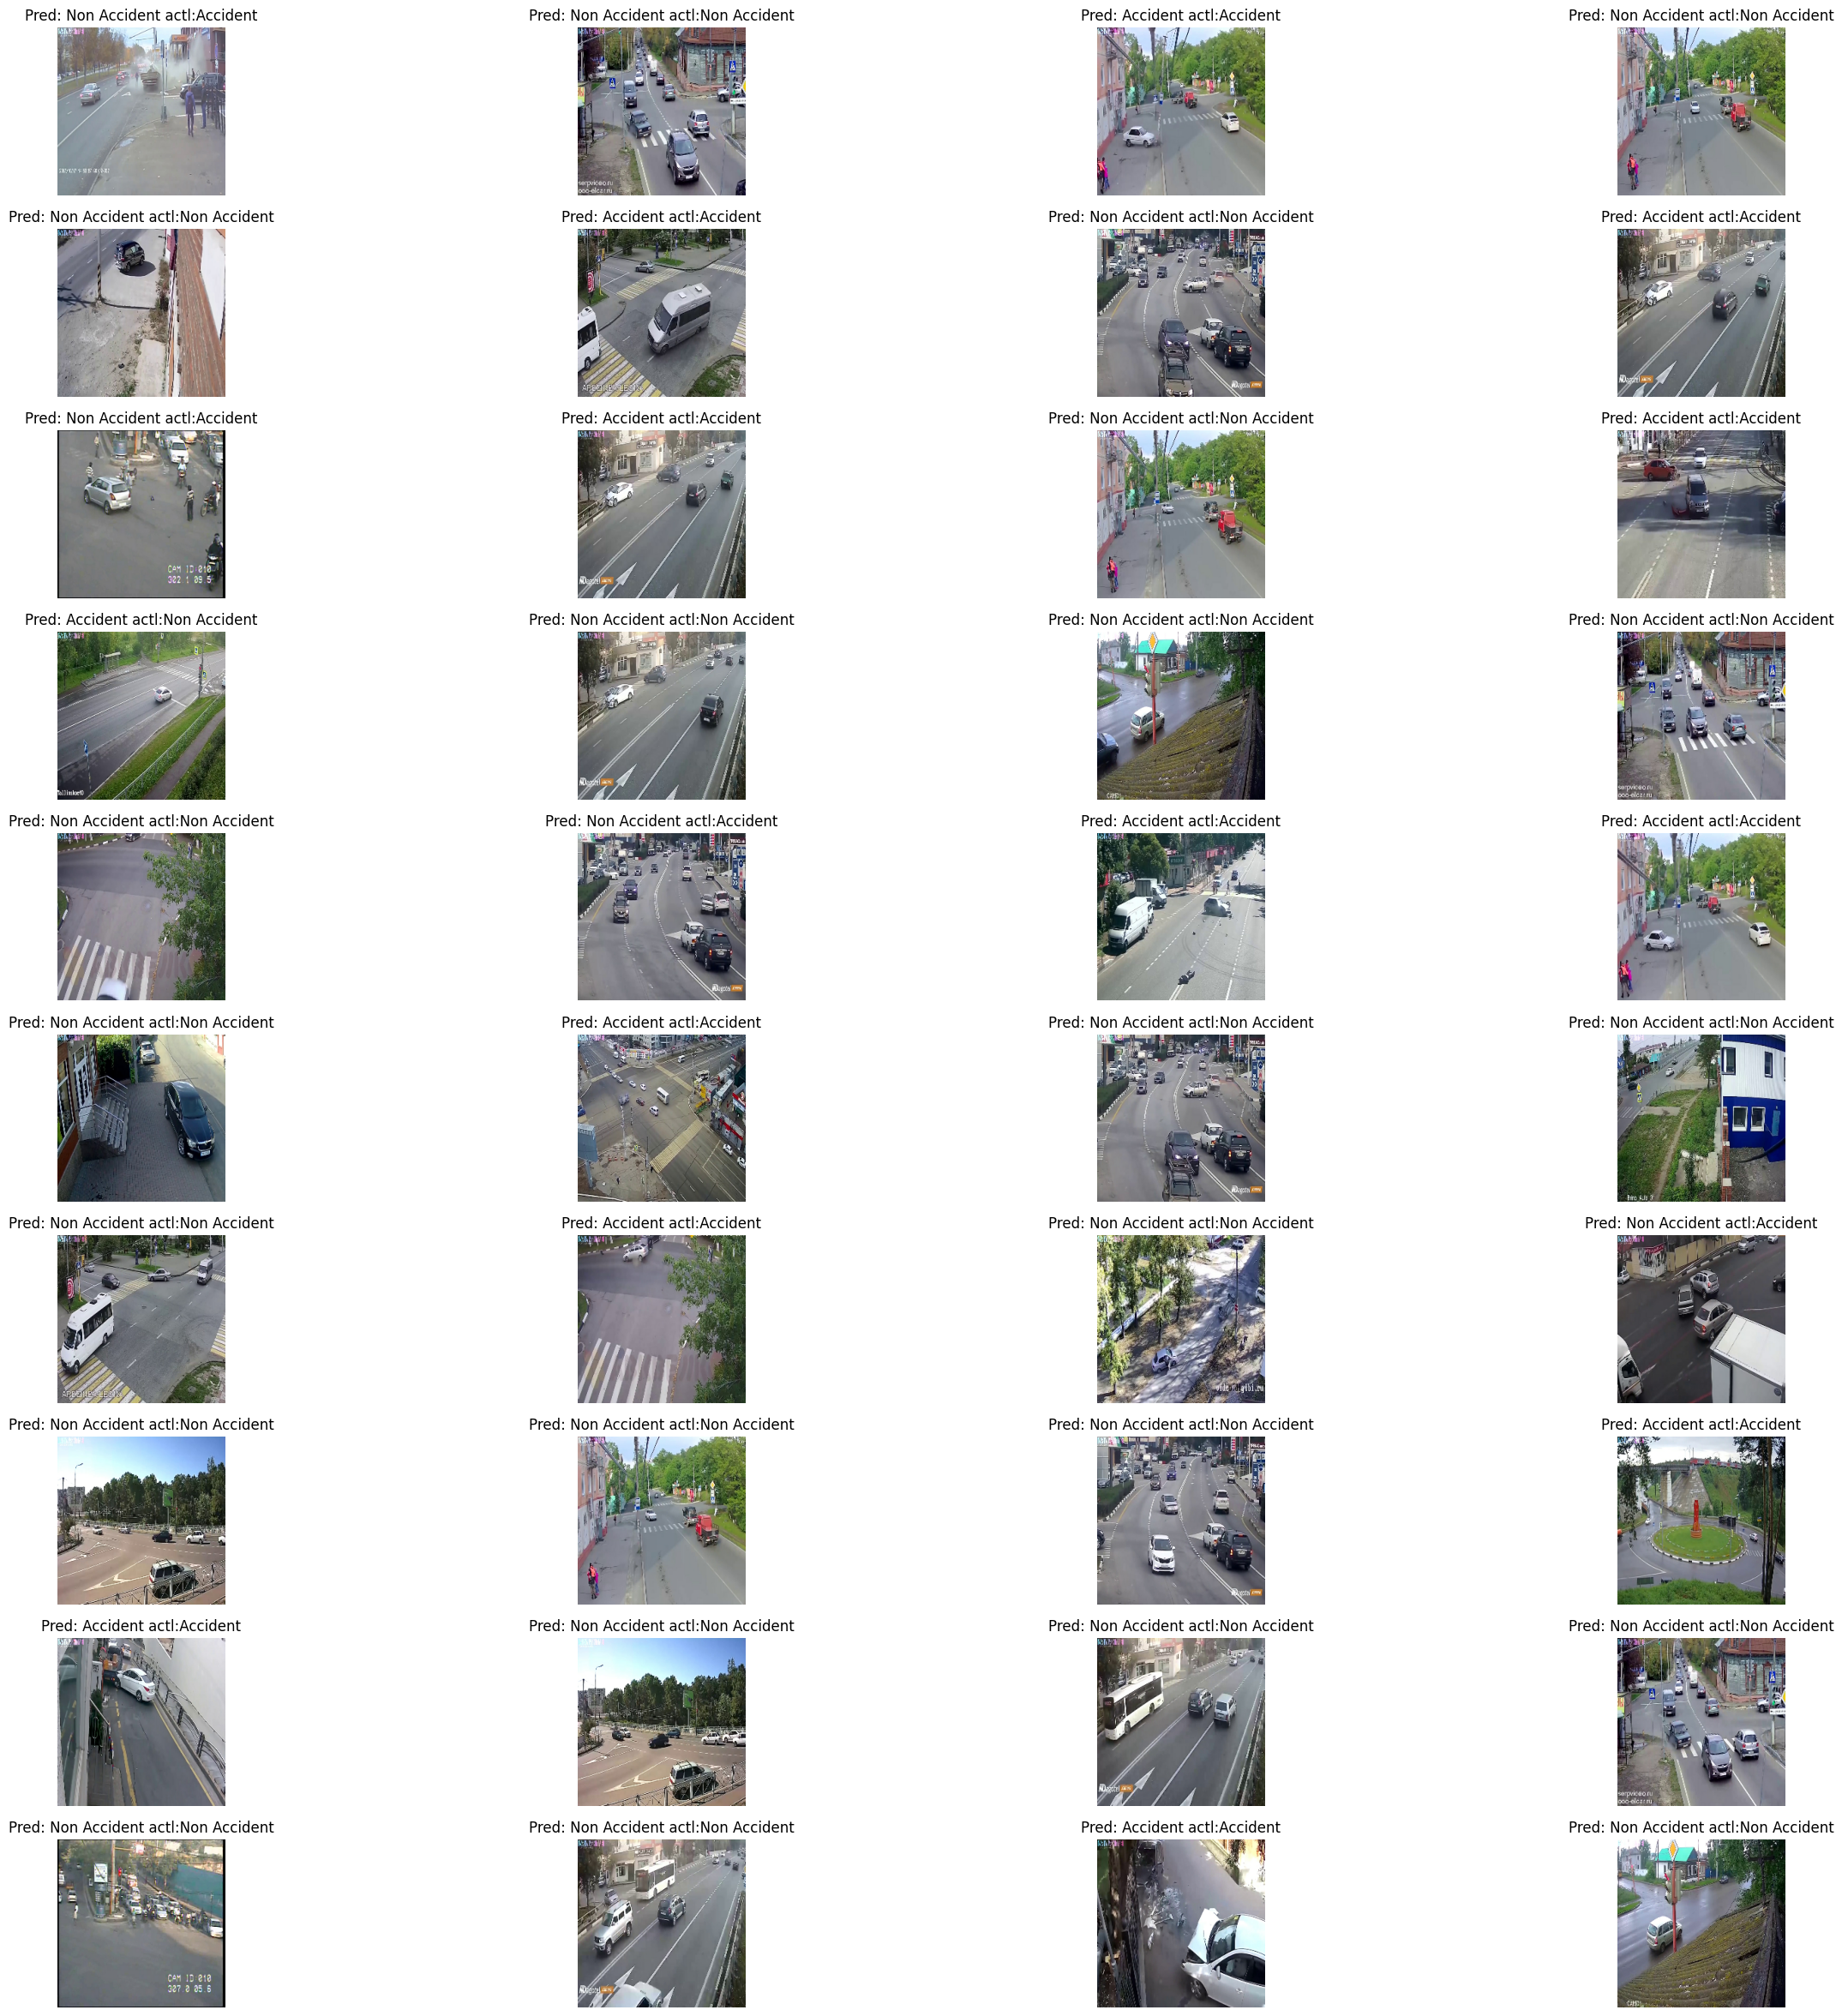

In [14]:
## lets vizualize results on testing data
AccuracyVector = []
plt.figure(figsize=(30, 30))
for images, labels in testing_data.take(1):
    predictions = model.predict(images)
    predlabel = []
    prdlbl = []
    
    for mem in predictions:
        predlabel.append(class_names[np.argmax(mem)])
        prdlbl.append(np.argmax(mem))
    
    AccuracyVector = np.array(prdlbl) == labels
    for i in range(40):
        ax = plt.subplot(10, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title('Pred: '+ predlabel[i]+' actl:'+class_names[labels[i]] )
        plt.axis('off')
        plt.grid(True)

In [15]:
###### serialize model structure to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

-----------------------------------------------------------------------------------------------------------------------------
AFTER SAVING THE MODEL ONCE YOU CAN  RUN IT FROM HERE

In [16]:

class AccidentDetectionModel:
    class_nums = ['Accident', 'No Accident']

    def __init__(self, model_json_file, model_weights_file):
        # load model from JSON file
        with open(model_json_file, 'r') as json_file:
            loaded_model_json = json_file.read()
            self.loaded_model = model_from_json(loaded_model_json)

        # load weights into the new model
        self.loaded_model.load_weights(model_weights_file)
        self.loaded_model.make_predict_function()

    def predict_accident(self, img):
        self.preds = self.loaded_model.predict(img)
        return AccidentDetectionModel.class_nums[np.argmax(self.preds)], self.preds

model = AccidentDetectionModel("model.json", "model_weights.h5")
font = cv2.FONT_HERSHEY_SIMPLEX

In [18]:
API_KEY = 'YOUR_API_KEY'
latitude = 28.4089 #add your current location latitude
longitude = 77.3178 # add your current location longitude
radius = 5000

In [19]:
def print_hospitals(hospitals):
    print("Nearby Hospitals:")
    print("-----------------------------------------------------------")
    print("{:<50} {:<15} {:<15}".format("Name", "Latitude", "Longitude"))
    print("-----------------------------------------------------------")
    for hospital in hospitals:
        print("{:<50} {:<15.7f} {:<15.7f}".format(hospital["name"], hospital["latitude"], hospital["longitude"]))
    print("-----------------------------------------------------------")


In [20]:
def find_nearby_hospitals(api_key, latitude, longitude, radius=5000):
    google_places = GooglePlaces(api_key)
    query_result = google_places.nearby_search(
        lat_lng={'lat': latitude, 'lng': longitude},
        radius=radius,
        types=[types.TYPE_HOSPITAL]
    )

    hospitals = []
    for place in query_result.places:
        hospital_info = {
            "name": place.name,
            "latitude": place.geo_location['lat'],
            "longitude": place.geo_location['lng']
        }
        hospitals.append(hospital_info)
    print_hospitals(hospitals)
    return hospitals


In [21]:
#to get a beep whenever we get into accident
def play_beep():
    if platform.system() == "Windows":
        import winsound
        winsound.Beep(1000, 500)  # Frequency, Duration
    else:
        os.system("no beep")

In [22]:
model = AccidentDetectionModel("model.json", 'model_weights.h5')
font = cv2.FONT_HERSHEY_SIMPLEX
#storing the model in model.json file

IF YOU WANT TO ACCESS YOUR WEBCAM USE THE BELOW LINE FOR VIDEO:-                                                             
video = cv2.VideoCapture(0)

In [30]:
from keras.models import model_from_json
import numpy as np
import cv2
import os

def startapplication():
    video = cv2.VideoCapture('accident_video.mp4') 
    frame_width = 640  # Adjust the desired width of the video frame
    frame_height = 480  # Adjust the desired height of the video frame

    # Create a resizable window
    cv2.namedWindow('Video', cv2.WINDOW_NORMAL)

    # Set the window size
    cv2.resizeWindow('Video', frame_width, frame_height)
    while True:
        ret, frame = video.read()
        if not ret:
            # Break the loop if there are no more frames in the video
            break

        gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        roi = cv2.resize(gray_frame, (250, 250))

        pred, prob = model.predict_accident(roi[np.newaxis, :, :])
        prob = (round(prob[0][0] * 100, 2))

        # to beep when alert:
        if prob > 90:
            play_beep()

            # Get nearby hospitals if an accident occurs


            #COMMENT THE BELOW THREE LINES IF YOU DONT HAVE GOOGLE API KEY

            
            if pred == "Accident":
                hospitals=find_nearby_hospitals(API_KEY, 28.4089, 77.3178)
                print_hospitals(hospitals)

        if pred == "Accident":
            cv2.rectangle(frame, (0, 0), (280, 40), (0, 0, 0), -1)
            cv2.putText(frame, pred + " " + str(prob), (20, 30), font, 1, (255, 255, 0), 2)
        elif prob < 40:
            cv2.rectangle(frame, (0, 0), (280, 40), (0, 0, 0), -1)
            cv2.putText(frame, "No Accident", (20, 30), font, 1, (255, 255, 0), 2)

        cv2.imshow('Video', frame)

        if cv2.waitKey(33) & 0xFF == ord('q'):
            break

    video.release()
    cv2.destroyAllWindows()

if __name__ == '__main__':
    startapplication()


1/1 [==============================] - 0s 45ms/step
Nearby Hospitals:
-----------------------------------------------------------
Name                                               Latitude        Longitude      
-----------------------------------------------------------
Sarvodaya Hospital                                 28.4222361      77.3167904     
Metro Heart Institute with Multispeciality         28.4060327      77.3180343     
Asian Institute of Medical Sciences                28.4260095      77.2999836     
Rawat Medical Store                                28.3928114      77.3019900     
Sparsh Hospital                                    28.4449953      77.3185976     
-----------------------------------------------------------
1/1 [==============================] - 0s 43ms/step
Nearby Hospitals:
-----------------------------------------------------------
Name                                               Latitude        Longitude      
---------------------------------------